# NEU502B: Homework 2

In this homework assignment, you will work through three commonly used methods in cognitive computational neuroscience: (1) neural decoding via multivariate pattern analysis (MVPA); (2) representational similarity analysis (RSA); and (3) voxelwise encoding analysis using regularized regression. Each of these problems builds on tools and ideas we've introduced in the in-class lab notebooks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Problem 1: Multivariate pattern classification

First, we'll start with a simple example of classifying distributed response patterns for different object categories from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). We'll begin by loading in the data, as well as labels for the stimuli and runs. You'll need to change `data_dir` to a directory on your computer (or the server); if you've already downloaded this dataset in lab, you can set `data_dir` to the existing directory to save time.

In [3]:
from nilearn import datasets
from nilearn.image import index_img
import pandas as pd

# Change this path to a directory on your computer!
data_dir = '/mnt/cup/people/tt1131/courses/502b_sp22/neu502b-lab/nilearn-data'

# Load the Haxby et al., 2001 data via Nilearn
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)

# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Create a boolean array indexing TRs containing a stimulus (non-rest)
task_trs = stimuli != 'rest'

# Get list of unique stimulus categories (excluding rest)
categories = [c for c in np.unique(stimuli) if c != 'rest']

# Extract task TRs for fMRI data and stimulus/run labels
func_task = index_img(haxby_dataset.func[0], task_trs)
stimuli_task = stimuli[task_trs]
runs_task = runs[task_trs]

Use `NiftiMasker` (with `standardize=True`) to create a masker for ventral temporal (VT) cortex. Use the masker to extract the the NumPy array containing the functional data. (We'll analyze the data using scikit-learn rather than nilearn.)

In [4]:
# Get the VT mask file and creater masker:
from nilearn.maskers import NiftiMasker

vt_mask = NiftiMasker(mask_img=haxby_dataset.mask_vt[0], standardize=True)
# Uses masker to extract numpy array for VT:
func_data_vt = vt_mask.fit_transform(func_task)

/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


Now, we'll set up a full SVM classification analysis using leave-one-run-out outer cross-validation with a nested leave-one-run-out inner cross-validation loop for grid search across the values of the SVM regularization parameter $C$. Sounds like a lot! But scikit-learn makes it pretty straightforward. First, initialize the `LinearSVC` estimator. Since this well-behaved dataset has the same number of samples for each stimulus category in each run, we can perform leave-one-run-out cross-validation using just `KFold` rather than having to specify the runs directly. Initalize an outer `KFold` cross-validator with 12 splits and an inner `KFold` cross-validator with 11 splits. We'll search over a handful of $C$ parameters: `param_grid = {'C': [1e-2, 1e-1, 1]}`. Initialize the `GridSearchCV` estimator with the SVM estimator, the parameter grid, and the inner cross-validator; then, submit this estimator to `cross_val_predict` with the outer cross-validator to run the full analysis. (This may take a few minutes to run!)

In [5]:
# Suppress some warnings (e.g. SVM convergence) just to clean up output
import warnings
from sklearn.model_selection import (cross_val_predict,
                                     GridSearchCV,
                                     KFold)
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize SVM and outer/inner CVs:
svm = LinearSVC()

innerCV = KFold(n_splits=11, 
                shuffle=True, 
                random_state=42)

outerCV = KFold(n_splits=12, 
                shuffle=True,
                random_state=42)
# Set up parameter grid:
param_grid = {"C": [1e-2, 1e-1, 1]}

# Initialize GridSearchCV estimator:
gs_cv = GridSearchCV(svm, 
                     param_grid, 
                     cv=innerCV)

# Generate predictions using cross_val_predict:
pred = cross_val_predict(gs_cv, 
                         func_data_vt, 
                         stimuli_task, 
                         cv=outerCV, 
                         groups=runs_task,
                         n_jobs = -1)

/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/people/tt1

Inspect the resulting predictions. We'll evaluate our classifier's predictions in two ways. First, use `accuracy_score` from `sklearn.metrics` to evaluate the predictions (across all test sets) against the actual labels in terms of a single classification accuracy. Procedurally, this is slightly different from computing accuracies on the test for each fold and averaging them—but the resulting value should be the same.

In [6]:
# Print accuracy score:
from sklearn.metrics import accuracy_score
print(f"The mean accuracy of the classifier's prdiction across all test set is {accuracy_score(stimuli_task, pred) * 100 :.2f}%")

The mean accuracy of the classifier's prdiction across all test set is 89.81%


To better understand what our classifer is doing (i.e. what it's getting right and what it's getting wrong), we'll construct a confusion matrix. Construct the confusion matrix from the actual stimulus labels and the classifer's predicted labels and plot it below. What categories does the classifier tend to misclassify?

Text(0.5, 1.0, 'SVM classifier confusion matrix with neural data from VT cortex')

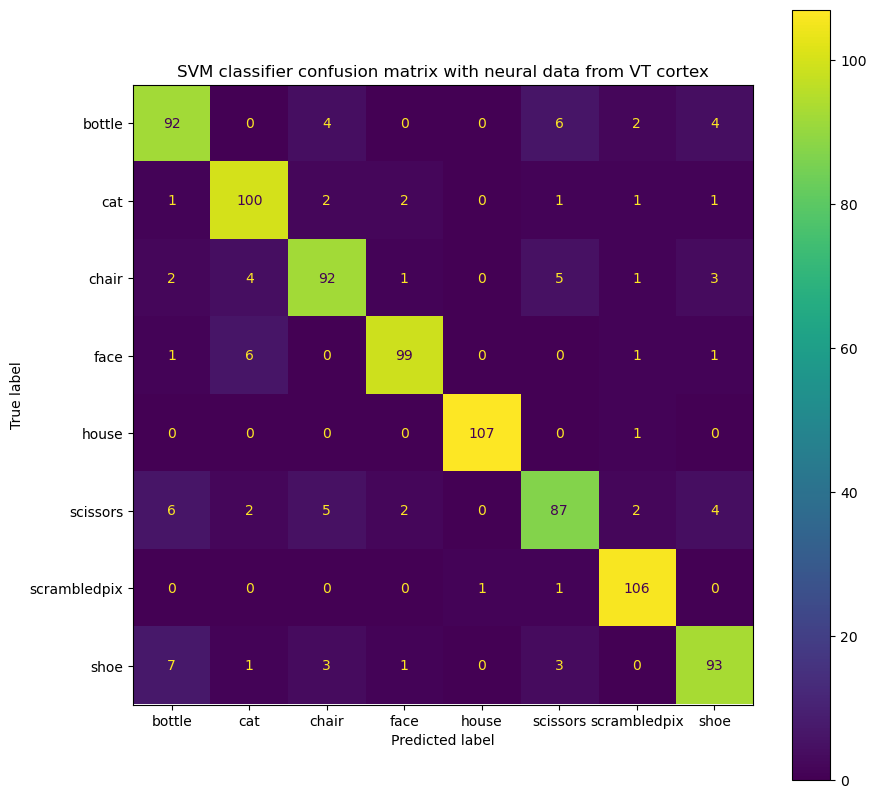

In [7]:
# Create confusion matrix from true and predicted labels:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix:
# Create confusion matrix from true and predicted labels:
cm = confusion_matrix(stimuli_task, pred)

# Plot confusion matrix:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=categories).plot(ax=ax)

ax.set_title("SVM classifier confusion matrix with neural data from VT cortex")

### Answer: The model is fairly good at predicting, but it tends to misclassify between bottle and shoe (7), bottle and scissors (6).

Lastly, we'll repeat the same analysis for functional regions of interest (ROIs) maximally responsive to faces (roughly FFA) and houses (roughly PPA). Use the `mask_face` and `mask_house` files from the dataset to create an FFA masker and a PPA masker; extract the functional data for both. Submit these datasets to the same analysis as above, and visualize the results in terms of an overall accuracy score and confusion matrix. Interpret the accuracies and confusion matrices in light of the expected chance accuracy, given what you know about these ROIs.

In [8]:
# Create masker for FFA:
ffa_masker = NiftiMasker(mask_img=haxby_dataset.mask_face[0], standardize=True)
# Create masker for PPA:
ppa_masker = NiftiMasker(mask_img=haxby_dataset.mask_house[0], standardize=True)

# Uses masker to extract numpy array for VT:
func_ffa = ffa_masker.fit_transform(func_task)
func_ppa = ppa_masker.fit_transform(func_task)

/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


In [ ]:
# Initialize SVM and outer/inner CVs:
svm = LinearSVC()

innerCV = KFold(n_splits=11, 
                shuffle=True, 
                random_state=42)

outerCV = KFold(n_splits=12, 
                shuffle=True,
                random_state=42)
# Set up parameter grid:
param_grid = {"C": [1e-2, 1e-1, 1]}

# Initialize GridSearchCV estimator:
gs_cv = GridSearchCV(svm, 
                     param_grid, 
                     cv=innerCV)

# Generate predictions using cross_val_predict:
ffa_pred = cross_val_predict(gs_cv, 
                             func_ffa, 
                             stimuli_task, 
                             cv=outerCV, 
                             groups=runs_task,
                             n_jobs = -1)

In [10]:
# Print accuracy score and plot confusion matrix:

# Print accuracy score:
from sklearn.metrics import accuracy_score
print(f"The mean accuracy of the classifier's prdiction across all test set for FFA region is {accuracy_score(stimuli_task, ffa_pred) * 100 :.2f}%")

The mean accuracy of the classifier's prdiction across all test set for FFA region is 37.73%


Text(0.5, 1.0, 'SVM classifier confusion matrix with neural data from FFA region')

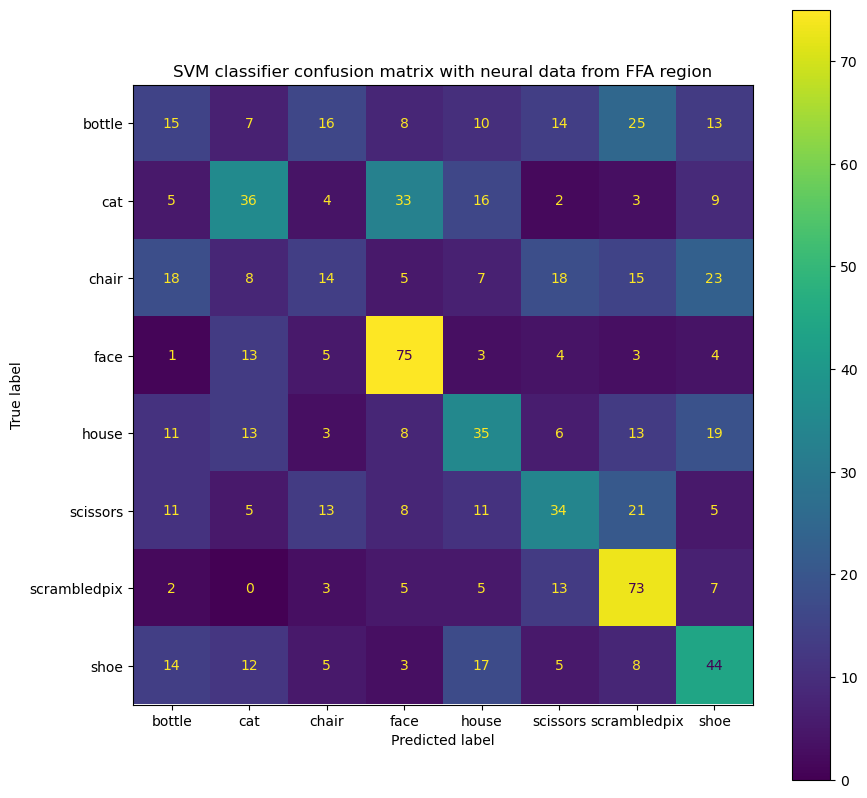

In [11]:
ffa_cm = confusion_matrix(stimuli_task, ffa_pred)

# Plot confusion matrix:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(ffa_cm, display_labels=categories).plot(ax=ax)
ax.set_title("SVM classifier confusion matrix with neural data from FFA region")

### Answer: Since the FFA region is traditioanlly regarded as the face region, the model is expected to have the higest decoding accuracy with face related images, which is shown in the confusion matrix. As compared with the scramblepix which can be regarded as complete chance accuracy, the model is able to decode face related images the best.

In [ ]:
# Initialize SVM and outer/inner CVs:
svm = LinearSVC()

innerCV = KFold(n_splits=11, 
                shuffle=True, 
                random_state=42)

outerCV = KFold(n_splits=12, 
                shuffle=True,
                random_state=42)
# Set up parameter grid:
param_grid = {"C": [1e-2, 1e-1, 1]}

# Initialize GridSearchCV estimator:
gs_cv = GridSearchCV(svm, 
                     param_grid, 
                     cv=innerCV)

# Generate predictions using cross_val_predict:
ppa_pred = cross_val_predict(gs_cv, 
                             func_ppa, 
                             stimuli_task, 
                             cv=outerCV, 
                             groups=runs_task,
                             n_jobs=-1)

In [13]:
# Print accuracy score and plot confusion matrix:
# Print accuracy score:
print(f"The mean accuracy of the classifier's prdiction across all test set for PPA region is {accuracy_score(stimuli_task, ppa_pred) * 100 :.2f}%")

The mean accuracy of the classifier's prdiction across all test set for PPA region is 65.86%


Text(0.5, 1.0, 'SVM classifier confusion matrix with neural data from PPA region')

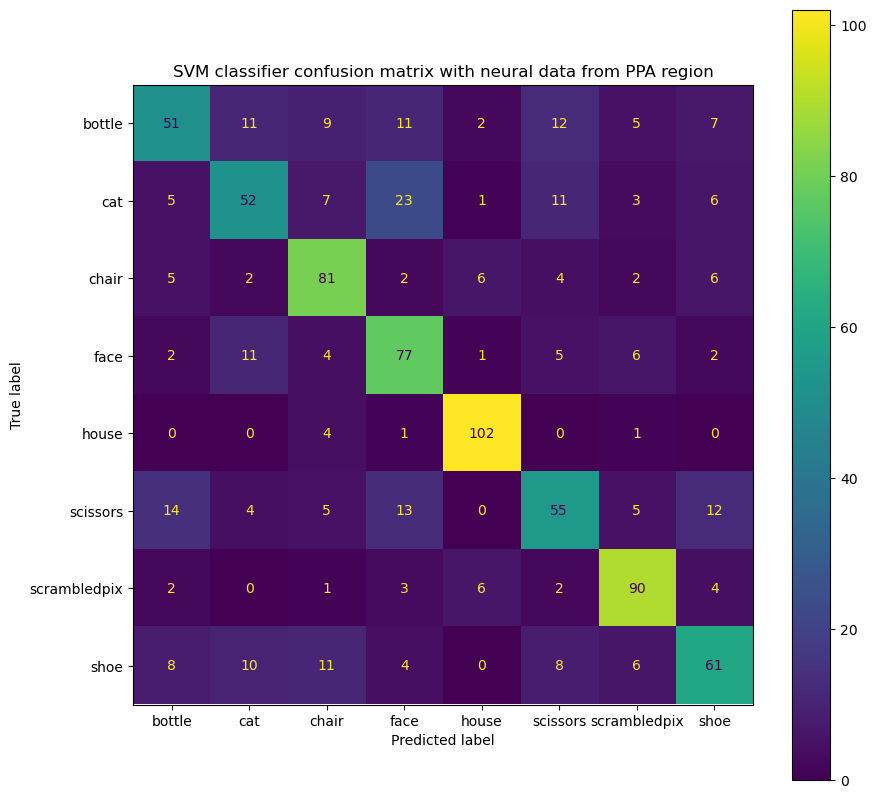

In [14]:
ppa_cm = confusion_matrix(stimuli_task, ppa_pred)

# Plot confusion matrix:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(ppa_cm, display_labels=categories).plot(ax=ax)
ax.set_title("SVM classifier confusion matrix with neural data from PPA region")

### Answer: Since the PPA region is regarded as the hosue region, the model is also expected to have the higest decoding accuracy with house related images, which is shown in the confusion matrix. PPA region, however, has decent decoding performance on other cateogries like chair when compared with the FFA region. Compared with scrambledpix, house is still the best decoded category which is consistent with our previous knowledge.

### Problem 2: Representational similarity analysis

In this problem, we'll apply representational similarity analysis (RSA) to the human fMRI dataset from [Kriegeskorte et al., 2008](https://doi.org/10.1016/j.neuron.2008.10.043). We'll begin by loading in the ROI data and labels.

In [15]:
# Load in Kriegekorte dataset and labels
kriegeskorte_dataset = dict(np.load('kriegeskorte_dataset.npz', allow_pickle=True))

roi_data = kriegeskorte_dataset['roi_data'].item()
category_names = kriegeskorte_dataset['category_names']
category_labels = kriegeskorte_dataset['category_labels']
images = kriegeskorte_dataset['images']
subject_labels = ['KO', 'SN', 'TI']
roi_labels = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

We provide a `rank_percentile` function for visualizing RDMs in a way that more closely matches the paper. 

In [16]:
from scipy.stats import rankdata

def rank_percentile(a):
    return rankdata(a) / len(a) * 100

First, compute RDMs for the `'lFFA'`, `'rFFA'`, `'lPPA'`, and `'rPPA'` ROIs for subject `'TI'` using correlation distance. Here, we recommend z-soring each voxel across samples prior to computing the pairwise dissimilarities. Plot the RDMs for each ROI using the `rank_percentile` function provided above.

Text(0.5, 0.98, 'Representational dissimilarity matrices for subject TI across brain regions')

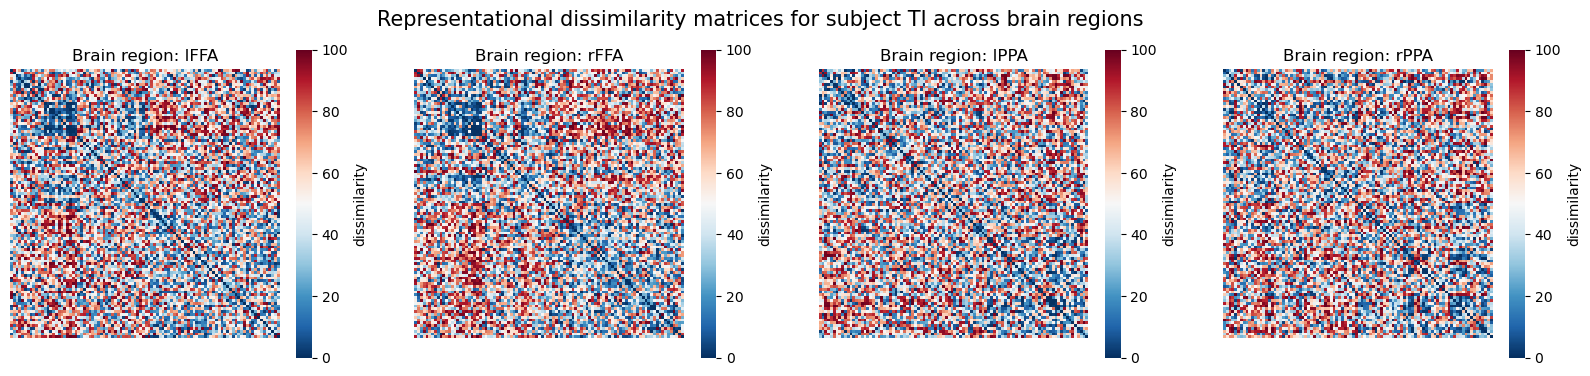

In [17]:
# Plot ROI RDMs for subject TI:
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

brain_region_labels = ["lFFA", "rFFA", "lPPA", "rPPA"]
subject_name = "TI"

rdm_dict = {}

fig, axs = plt.subplots(1, len(brain_region_labels), figsize=(20, 4))

# Get data for subject TI:
for idx, region in enumerate(brain_region_labels):
    pdst_zscore_data = pdist(zscore(roi_data[subject_name][region], axis=0), 
                             metric = "correlation")
    rdm_dict[region] = pdst_zscore_data
    sns.heatmap(squareform(rank_percentile(pdst_zscore_data)),
                square=True, cmap='RdBu_r',
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'dissimilarity'},
                ax = axs[idx])
    axs[idx].set_title(f"Brain region: {region}")
    
plt.suptitle("Representational dissimilarity matrices for subject TI across brain regions", fontsize=15)

RSA allows us to compare the representational geometries of different ROIs. Compute the correlation between each pair of the four ROIs. Plot this similarity matrix. Which ROIs have the most similar representational geometries?

Text(0.5, 1.0, 'Similarity matrix of RDMs across brain regions')

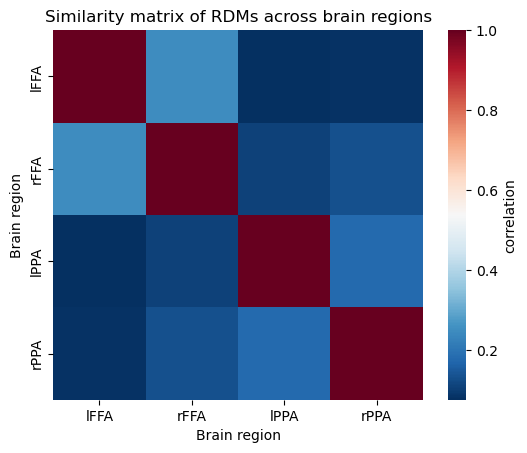

In [18]:
from scipy.stats import spearmanr
# Compute correlations between each pair or ROI RDMs:

region_corr_mtx = np.zeros(len(brain_region_labels) ** 2).reshape(len(brain_region_labels), len(brain_region_labels))

for i, region_i in enumerate(brain_region_labels):
    for j, region_j in enumerate(brain_region_labels):
        region_corr_mtx[i, j] = spearmanr(rdm_dict[region_i], rdm_dict[region_j])[0]
# Plot correlation matrix:    

fig, ax = plt.subplots()
sns.heatmap(region_corr_mtx, 
            square=True, cmap='RdBu_r', 
            xticklabels=brain_region_labels,
            yticklabels=brain_region_labels,
            cbar_kws={'label': 'correlation'},
            ax = ax)

ax.set_xlabel("Brain region")
ax.set_ylabel("Brain region")

ax.set_title("Similarity matrix of RDMs across brain regions")

## Answer: rFFA and lFFA share the most similar representational geometries. lPPA and rPPA are the second most similar pair of brain regions with respect to their representational geometries.

Stack all four ROIs to create a single combined ROI for each subject `'SN'` and `'TI'`. What is the Spearman correlation between `'SN'`'s and `'TI'`'s representational geometries?

In [19]:
# Combine SN and TI ROIs into single VT ROI and compute RDMs:
from scipy.stats import spearmanr
SN_stacked_ROis = np.hstack((roi_data['SN']['lFFA'], 
                            roi_data['SN']['rFFA'], 
                            roi_data['SN']['lPPA'],
                            roi_data['SN']['rPPA']))


TI_stacked_ROis = np.hstack((roi_data['TI']['lFFA'], 
                            roi_data['TI']['rFFA'], 
                            roi_data['TI']['lPPA'], 
                            roi_data['TI']['rPPA']))

# Compute correlations between SN and TI's VT RDMs:
SN_rdm = pdist(zscore(SN_stacked_ROis, axis=0), metric = "correlation")
TI_rdm = pdist(zscore(TI_stacked_ROis, axis=0), metric = "correlation")

print(f"The spearman correlation between patients SN and TI's representational geometries is {spearmanr(SN_rdm, TI_rdm)[0]:.2f}")

The spearman correlation between patients SN and TI's representational geometries is 0.39


We can test different "model" RDMs according to how well they approximate a given neural. Here, for the sake of brevity, we'll construct an extremely simple RDM capturing low-level visual structure. Flatten each image file into a one-dimensional array of pixel values (across three color channels). Next, compute the pairwise Euclidean distances between these image vectors to construct an RDM capture low-level visual similarities. Plot this pixel RDM and compute it's Spearman correlation with `'TI'`s VT RDM?

The spearman correlation between SN and TI's representational geometries is 0.05


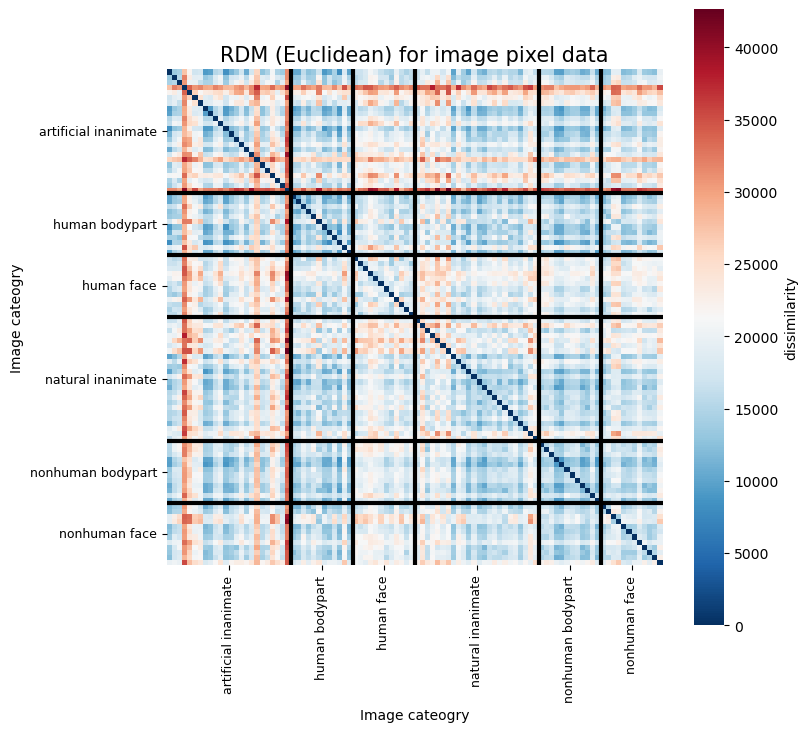

In [38]:
from einops import rearrange

category_reorder_idx = np.argsort(category_labels)
category_labels_reorded = category_labels[category_reorder_idx]

_, counts = np.unique(category_labels_reorded, return_counts=True)
plot_idx = counts // 2 + np.concatenate([[0], np.cumsum(counts)[:-1]])

flattened_image = rearrange(images, 'i h w c -> i (h w c)')[category_reorder_idx, :]

fig, ax = plt.subplots(figsize = (8, 8))
pixel_rdm = pdist(flattened_image, metric = "euclidean")
f = sns.heatmap(squareform(pixel_rdm), square=True, cmap='RdBu_r', 
                cbar_kws={'label': 'dissimilarity'},
                ax = ax)

_ = f.set_xticks(plot_idx)
_ = f.set_yticks(plot_idx)

_ = f.set_xticklabels(category_names, rotation=90, fontsize=9)
_ = f.set_yticklabels(category_names, fontsize=9)

for line in np.cumsum(counts)[:-1]:
    ax.axhline(y=line, color='k', linewidth=3)
    ax.axvline(x=line, color='k', linewidth=3)
    
ax.set_title("RDM (Euclidean) for image pixel data", fontsize=15)
ax.set_xlabel("Image cateogry", fontsize=10)
ax.set_ylabel("Image cateogry", fontsize=10)

print(f"The spearman correlation between SN and TI's representational geometries is {spearmanr(pixel_rdm, TI_rdm)[0]:.2f}")

### Problem 3: Voxelwise encoding analysis

In this problem, we'll return to *encoding analysis*, using regularized regression and out-of-sample prediction in individual voxels. We will use word embeddings derived from the natural language processing (NLP) model GloVe to map semantic encoding onto the brain. You can simply load the `story_transcript.txt` file in a text editor to visualize the transcript for the spoken story by [Carol Daniel](https://themoth.org/stories/i-knew-you-were-black). Each line of this file corresponds to a TR in the fMRI data. Next, we extracted word embeddings from GloVe for each word in each TR. For TRs containing multiple words, we averaged the embeddings. Finally, we horizontally stacked the embeddings at lags of 2, 3, 4, and 5 TRs (3, 4.5, 6, and 7.5 seconds relative to word onset) to account variable hemodynamic lags (this is effectively a finite impulse response model). Inspect and interpret the shape of the word embeddings, and visualize this matrix.

In [21]:
# Load and visualize word embeddings:
tc_path = '/mnt/cup/people/tt1131/courses/502b_sp22/neu502b-lab/homework/story_transcript.txt'
with open(tc_path) as f:
    transcript_trs = [line.strip().split(",") for line in f.readlines()]
    
print("Example words in the story per TR:")
for i in [3, 5]:
    print(transcript_trs[i])

Example words in the story per TR:
['was', 'a', 'junior']
['when', 'I', 'got', 'my', 'first']


(538, 1200)


Text(0.5, 1.0, 'GloVe embeddings feature matrix with variable lag for story transcript')

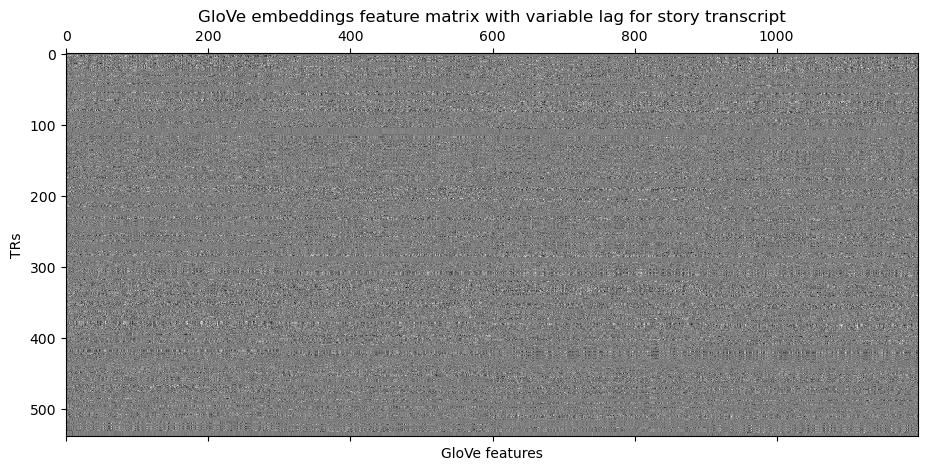

In [29]:
embedding_path = "/mnt/cup/people/tt1131/courses/502b_sp22/neu502b-lab/homework/story_embeddings.npy"

story_embeddings_lag = np.load(embedding_path)
print(story_embeddings_lag.shape)

fig, ax = plt.subplots(figsize = (11, 6))
ax.matshow(story_embeddings_lag, cmap='binary_r')
ax.set_xlabel('GloVe features')
ax.set_ylabel('TRs')

ax.set_title("GloVe embeddings feature matrix with variable lag for story transcript")

### Answer: The first dimension corresponds to the time dimension, and the second dimensions corresponds to the GloVe embedding dimension with multiple random time lags stacked before and after the embedding to account for the hemodynamic lags.

We used fMRI to measure a subject's brain activity while they listened to the spoken story. Here, to reduce computational demands, we have spatially downsampled the fMRI data using an atlas containing 400 parcels. That is, for each parcel, we averaged the voxel time series within that parcel. Rather than fitting encoding models to tens of thousands of voxels, we'll fit our encoding model to each of the 400 parcels. Load in the `story_parcels.npy` dataset as well as the `story_atlas.nii.gz` NIfTI image from which the parcels were derived (for later visualization).

In [23]:
# Load in parcel time series:
parcels_path = '/mnt/cup/people/tt1131/courses/502b_sp22/neu502b-lab/homework/story_parcels.npy'
func_parcels = np.load(parcels_path)

# Load in the Schaefer 400-parcel atlas:
import nibabel as nib
atlas_path = '/mnt/cup/people/tt1131/courses/502b_sp22/neu502b-lab/homework/story_atlas.nii.gz'
atlas_nii = nib.load(atlas_path)
atlas_img = atlas_nii.get_fdata()

Our word embedding "model" is much wider than the number of samples, so we'll need to use regularization and out-of-sample prediction to mitigate overfitting. We'll use ridge regression to fit encoding models to predict the parcel time series from the word embeddings. First, set up an split-half outer cross-validator using `KFold` with `n_splits=2`; next, set up an inner cross-validator using `KFold` with `n_splits=5` to perform grid search for the `alpha` hyperparameter using 5-fold cross-validation within each training set of the otuer loop. Initialize your `RidgeCV` estimator with the inner cross-validator and the following grid of alphas: `alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]`. For each training and testing split of the other cross-validation loop, fit the ridge model on the training set of embeddings and parcel time series, and generate predicted parcel time series from the test embeddings. Compile these predicted parcel time series for model evaluation in the next step:

In [24]:
# Set up outer/inner cross-validators:
from sklearn.model_selection import KFold
outer_cv = KFold(n_splits=2, 
                 shuffle=True, 
                 random_state=42)
inner_cv = KFold(n_splits=5, 
                 shuffle=True,
                 random_state=42)

# Initialize RidgeCV with alpha grid and inner CV:
from sklearn.linear_model import RidgeCV

alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge_est = RidgeCV(alphas=alphas, cv=inner_cv, scoring='r2')

# Loop through outer CV loop, fit model, generate predictions:
func_predicted = []
for train, test in outer_cv.split(func_parcels):
    
    # Fit ridge regression with grid search
    ridge_est.fit(story_embeddings_lag[train], func_parcels[train])
    
    # Compute predicted response
    predicted = ridge_est.predict(story_embeddings_lag[test])
    func_predicted.append(predicted)
    
# Restack first and second half predictions
func_predicted = np.vstack(func_predicted)

To evaluate our encoding model's predictions, correlate the predicted parcel time series with the actual parcel time series for each parcel. 

In [25]:
# Compute correlation between predicted and actual responses:
from scipy.stats import pearsonr

r_parcels = []
for parcel in np.arange(func_parcels.shape[1]):
    r_parcels.append(pearsonr(func_parcels[:, parcel],
                              func_predicted[:, parcel])[0])

Finally, to visualize the performance of our semantic encoding model on the brain, we need to use the atlast NIfTI image to convert from parcels back to the original brain image. You can start by creating an empty brain image (i.e. zeros) the size of the atlas image. Next, loop through each parcel and insert the prediction scores (i.e. correlations between actual and predicted parcel time series) into all voxels where the atlas correponds to that parcel label. Convert this image to a NIfTI image and visualize with `plot_stat_map`; you may want to set a particular `vmax` and use a `threshold` to exclude voxels with poor prediction performance for the sake of visualization.

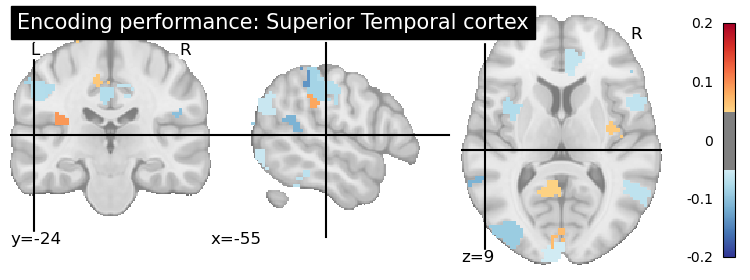

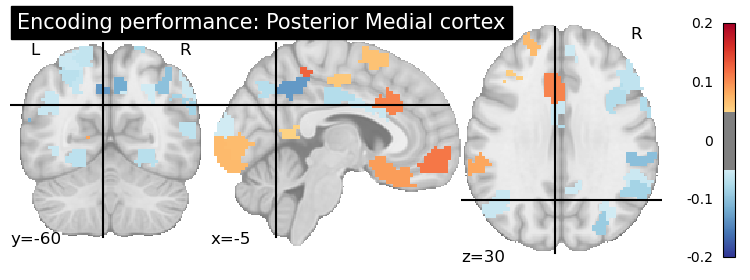

In [35]:
# Create an empty brain image and populate with parcelwise performance values:
from nilearn.plotting import plot_stat_map

r_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    r_img[atlas_img == parcel] = r_parcels[i]

# Convert to NIfTI image for visualization with Nilearn
r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)

# Plot correlations to visualize superior temporal cortex
vmax = .2
threshold = .05
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title='Encoding performance: Superior Temporal cortex', 
              cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title = 'Encoding performance: Posterior Medial cortex', 
              cut_coords=(-5, -60, 30))